In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram

import mlflow
import mlflow.sklearn


In [2]:
df = pd.read_csv(r"C:\Users\asmis\OneDrive\Desktop\patroliq_V1\patroliq\data\processed\feature_engineered_data.csv")


In [3]:
geo_features = df[["Latitude", "Longitude"]]


In [4]:
mlflow.set_experiment("Geographic Crime Clustering")

with mlflow.start_run(run_name="KMeans_Geo"):
    kmeans = KMeans(n_clusters=6, random_state=42)
    df["Geo_Cluster_KMeans"] = kmeans.fit_predict(geo_features)

    sil_score = silhouette_score(geo_features, df["Geo_Cluster_KMeans"])
    db_score = davies_bouldin_score(geo_features, df["Geo_Cluster_KMeans"])

    mlflow.log_param("algorithm", "KMeans")
    mlflow.log_param("clusters", 6)
    mlflow.log_metric("silhouette_score", sil_score)
    mlflow.log_metric("davies_bouldin", db_score)

    print("Silhouette Score:", sil_score)


2026/02/05 17:39:33 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/05 17:39:33 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/05 17:39:33 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/05 17:39:33 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/05 17:39:33 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/05 17:39:33 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/05 17:39:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/05 17:39:34 INFO mlflow.store.db.utils: Updating database tables
2026/02/05 17:39:34 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/05 17:39:34 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/05 17:39:35 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/05 17:39:35 INFO alembic.runtime

Silhouette Score: 0.4119416403852074


In [5]:
geo_sample = geo_features.sample(50_000, random_state=42)


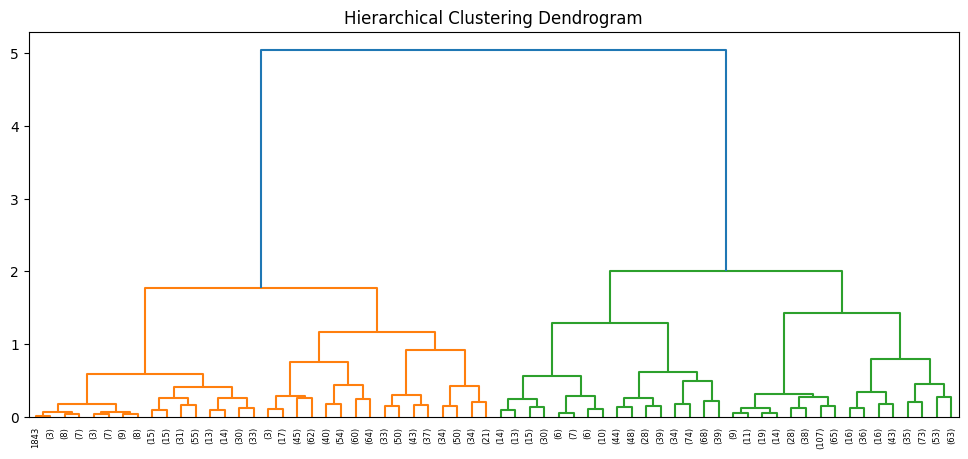

In [6]:
sample_geo = geo_features.sample(2000, random_state=42)

Z = linkage(sample_geo, method="ward")

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


In [7]:
with mlflow.start_run(run_name="DBSCAN_Geo_Sampled"):
    dbscan = DBSCAN(eps=0.01, min_samples=50, n_jobs=-1)
    labels = dbscan.fit_predict(geo_sample)

    # Remove noise for evaluation
    mask = labels != -1
    if len(set(labels[mask])) > 1:
        sil_score = silhouette_score(geo_sample[mask], labels[mask])
    else:
        sil_score = -1

    mlflow.log_param("algorithm", "DBSCAN")
    mlflow.log_param("sample_size", 50000)
    mlflow.log_param("eps", 0.01)
    mlflow.log_metric("silhouette_score", sil_score)

    print("DBSCAN Silhouette (sampled):", sil_score)


DBSCAN Silhouette (sampled): 0.1489903029414119


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["Day_Encoded"] = le.fit_transform(df["Day_of_Week"])

temporal_features = df[["Hour", "Month", "Day_Encoded", "Is_Weekend"]]


In [9]:
from sklearn.cluster import MiniBatchKMeans

with mlflow.start_run(run_name="MiniBatchKMeans_Temporal"):

    kmeans_time = MiniBatchKMeans(
        n_clusters=4,
        random_state=42,
        batch_size=2048
    )

    df["Time_Cluster"] = kmeans_time.fit_predict(temporal_features)

    sample_idx = df.sample(10_000, random_state=42).index
    sil_time = silhouette_score(
        temporal_features.loc[sample_idx],
        df.loc[sample_idx, "Time_Cluster"]
    )

    mlflow.log_metric("silhouette_score", sil_time)


In [10]:
df.to_csv(r"C:\Users\asmis\OneDrive\Desktop\patroliq_V1\patroliq\data\processed\clustered_data.csv", index=False)
